In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [2]:
df = pd.read_csv("/content/BNB-USD.csv")

In [3]:
# Kiểm tra dữ liệu
print(df.head())
print(df.info())

         Date       Open       High        Low      Close  Adj Close  \
0  2019-03-01  10.356931  11.607489  10.325634  11.393217  11.393217   
1  2019-03-02  11.384693  11.915753  10.960816  11.869744  11.869744   
2  2019-03-03  11.845305  11.964979  11.352064  11.537903  11.537903   
3  2019-03-04  11.538013  11.599405  11.070543  11.545945  11.545945   
4  2019-03-05  11.520388  13.841443  11.520388  13.811967  13.811967   

      Volume  
0  117838677  
1  120807894  
2   89868246  
3   89421231  
4  237026335  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1920 non-null   object 
 1   Open       1920 non-null   float64
 2   High       1920 non-null   float64
 3   Low        1920 non-null   float64
 4   Close      1920 non-null   float64
 5   Adj Close  1920 non-null   float64
 6   Volume     1920 non-null   int64  
dtypes: flo

In [4]:
# Sử dụng cột 'Close' làm dữ liệu để dự đoán
df1 = df['Close'].values.reshape(-1, 1)

In [5]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [6]:
# Chia dữ liệu thành tập train và test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# Kiểm tra kích thước của tập train và test
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [8]:
# Hàm tạo dataset từ chuỗi dữ liệu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# Tạo các tập X và Y từ dữ liệu train và test
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
# Định hình lại dữ liệu để phù hợp với đầu vào của TimesNet
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Xây dựng mô hình TimesNet
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 16ms/step - loss: 0.0319
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0048
Epoch 3/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0029
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0025
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0023
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0021
Epoch 7/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0021
Epoch 8/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0017
Epoch 9/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0022
Epoch 10/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0020
Epoch 11/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 12/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0015
Epoch 13/100
20/20 [=====

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [14]:
# Chuyển đổi giá trị về phạm vi gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
# Đánh giá mô hình
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mse = np.mean((y_test - test_predict)**2)

print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)

Test RMSE: 12.845541601425136
Test MAPE: 2.8324863755273437
Test MSE: 165.00793903394384


In [17]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

In [18]:

x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0
while i < 60:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

In [19]:

x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0
while i < 90:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

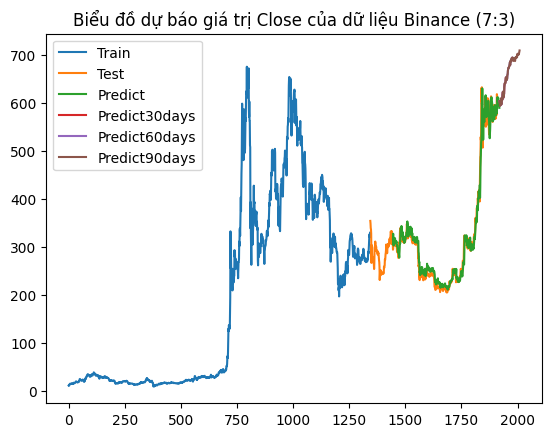

In [20]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predict))
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(predict_data_index,scaler.inverse_transform(lst_output))
predict_data_index_60 = pd.RangeIndex(start=len(df1), stop=len(df1)+60, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60))
predict_data_index_90 = pd.RangeIndex(start=len(df1), stop=len(df1)+90, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title("Biểu đồ dự báo giá trị Close của dữ liệu Binance (7:3)")
plt.show()

In [21]:
x_input.shape

(1, 100, 1)

In [22]:
train_size_82 = int(0.8 * len(df1))
test_size_82 = len(df1) - train_size_82
train_data_82 = df1[:train_size_82]
test_data_82 = df1[train_size_82:train_size_82+test_size_82]

In [23]:
X_train_82, y_train_82 = create_dataset(train_data_82, time_step)
X_test_82, ytest_82 = create_dataset(test_data_82, time_step)

In [24]:
X_train_82 =X_train_82.reshape(X_train_82.shape[0],X_train_82.shape[1] , 1)
X_test_82 = X_test_82.reshape(X_test_82.shape[0],X_test_82.shape[1] , 1)

In [25]:
model.fit(X_train_82,y_train_82,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 0s 13ms/step - loss: 4.8195e-04
Epoch 2/100
23/23 [==============================] - 0s 16ms/step - loss: 4.1103e-04
Epoch 3/100
23/23 [==============================] - 0s 17ms/step - loss: 3.8137e-04
Epoch 4/100
23/23 [==============================] - 1s 21ms/step - loss: 4.5719e-04
Epoch 5/100
23/23 [==============================] - 1s 22ms/step - loss: 3.7588e-04
Epoch 6/100
23/23 [==============================] - 1s 24ms/step - loss: 3.6999e-04
Epoch 7/100
23/23 [==============================] - 0s 20ms/step - loss: 3.7806e-04
Epoch 8/100
23/23 [==============================] - 0s 21ms/step - loss: 5.3162e-04
Epoch 9/100
23/23 [==============================] - 0s 18ms/step - loss: 3.7968e-04
Epoch 10/100
23/23 [==============================] - 1s 25ms/step - loss: 3.4008e-04
Epoch 11/100
23/23 [==============================] - 1s 29ms/step - loss: 3.3736e-04
Epoch 12/100
23/23 [==============================] - 1s 25ms/s

In [26]:
train_predict_82 = model.predict(X_train_82)
test_predict_82 = model.predict(X_test_82)

9/9 [==============================] - 0s 3ms/step


In [27]:
train_predict_82 = scaler.inverse_transform(train_predict_82)
test_predict_82 = scaler.inverse_transform(test_predict_82)
y_train_82 = scaler.inverse_transform(y_train_82.reshape(-1, 1))
ytest_82 = scaler.inverse_transform(ytest_82.reshape(-1, 1))

In [28]:
train_82_rmse = np.sqrt(np.mean((train_predict_82 - y_train_82)**2))
test_82_rmse = np.sqrt(np.mean((test_predict_82 - ytest_82)**2))
test_82_mape = np.mean(np.abs((ytest_82 - test_predict_82) / ytest_82)) * 100
test_82_mse = np.mean((ytest_82 - test_predict_82)**2)

print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Test RMSE: 15.721537243544645
Test MAPE: 2.803030820696076
Test MSE: 247.16673330016135


In [29]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

In [30]:
x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0
while i < 60:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

In [31]:

x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0
while i < 90:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

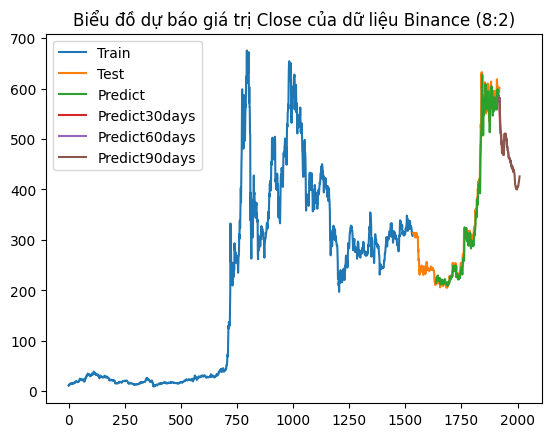

In [33]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_82, step=1)
plt.plot(scaler.inverse_transform(train_data_82))
test_data_index = pd.RangeIndex(start=train_size_82, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_82))
test_data_index = pd.RangeIndex(start=train_size_82+101, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,(test_predict_82))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
predict_data_index_60 = pd.RangeIndex(start=len(df1), stop=len(df1)+60, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60))
predict_data_index_90 = pd.RangeIndex(start=len(df1), stop=len(df1)+90, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title("Biểu đồ dự báo giá trị Close của dữ liệu Binance (8:2)")
plt.show()

In [34]:
train_size_91 = int(0.9 * len(df1))
test_size_91 = len(df1) - train_size_91
train_data_91 = df1[:train_size_91]
test_data_91 = df1[train_size_91:train_size_91+test_size_91]

In [35]:
X_train_91, y_train_91 = create_dataset(train_data_91, time_step)
X_test_91, ytest_91 = create_dataset(test_data_91, time_step)

In [36]:
X_train_91 =X_train_91.reshape(X_train_91.shape[0],X_train_91.shape[1] , 1)
X_test_91 = X_test_91.reshape(X_test_91.shape[0],X_test_91.shape[1] , 1)

In [37]:
model.fit(X_train_91,y_train_91,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 0s 11ms/step - loss: 2.3491e-04
Epoch 2/100
26/26 [==============================] - 0s 11ms/step - loss: 2.5544e-04
Epoch 3/100
26/26 [==============================] - 0s 11ms/step - loss: 2.4998e-04
Epoch 4/100
26/26 [==============================] - 0s 11ms/step - loss: 2.6627e-04
Epoch 5/100
26/26 [==============================] - 0s 12ms/step - loss: 2.3782e-04
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 2.7258e-04
Epoch 7/100
26/26 [==============================] - 0s 11ms/step - loss: 4.5909e-04
Epoch 8/100
26/26 [==============================] - 0s 12ms/step - loss: 2.6375e-04
Epoch 9/100
26/26 [==============================] - 0s 10ms/step - loss: 3.4459e-04
Epoch 10/100
26/26 [==============================] - 0s 10ms/step - loss: 2.8587e-04
Epoch 11/100
26/26 [==============================] - 0s 12ms/step - loss: 2.5448e-04
Epoch 12/100
26/26 [==============================] - 0s 11ms/s

In [38]:
train_predict_91 = model.predict(X_train_91)
test_predict_91 = model.predict(X_test_91)

3/3 [==============================] - 0s 8ms/step


In [39]:
train_predict_91 = scaler.inverse_transform(train_predict_91)
test_predict_91 = scaler.inverse_transform(test_predict_91)
y_train_91 = scaler.inverse_transform(y_train_91.reshape(-1, 1))
ytest_91 = scaler.inverse_transform(ytest_91.reshape(-1, 1))

In [41]:
train_91_rmse = np.sqrt(np.mean((train_predict_91 - y_train_91)**2))
test_91_rmse = np.sqrt(np.mean((test_predict_91 - ytest_91)**2))
test_91_mape = np.mean(np.abs((ytest_91 - test_predict_91) / ytest_91)) * 100
test_91_mse = np.mean((ytest_91 - test_predict_91)**2)

print('Test RMSE:', test_91_rmse)
print('Test MAPE:', test_91_mape)
print('Test MSE:', test_91_mse)

Test RMSE: 25.311224497462465
Test MAPE: 3.392520554209597
Test MSE: 640.6580855609441


In [42]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

In [43]:
x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0
while i < 60:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

In [44]:

x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0
while i < 90:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i += 1

0 day input [0.54920325 0.55884414 0.56906318 0.58871229 0.57873439 0.60991559
 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403 0.57823327
 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459 0.77042396
 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461 0.84301543
 0.81820905 0.74694881 0.82142588 0.81624461 0.8140389  0.81419041
 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035  0.90540851
 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903 0.86456128
 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064 0.90154532
 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373 0.79310349
 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406 0.89477894
 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883  0.88651788
 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594 0.86516916
 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575 0.86483242
 0.87444629 0.87804328 0.8738145  0.83644398 0.8595077  0.84017087
 0.85816297 0.85711658 0.84833749 0.88733608 0.914

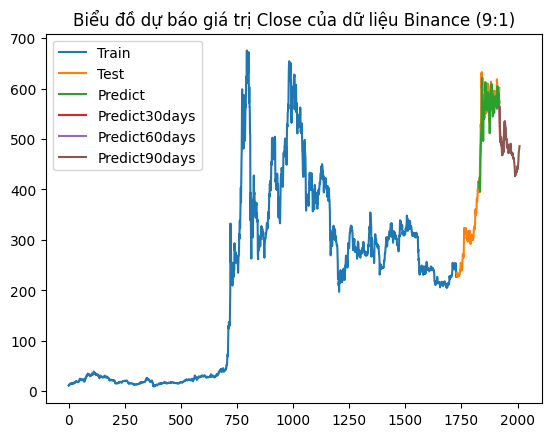

In [45]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_91, step=1)
plt.plot(scaler.inverse_transform(train_data_91))
test_data_index = pd.RangeIndex(start=train_size_91, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_91))
test_data_index = pd.RangeIndex(start=train_size_91+101, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,(test_predict_91))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
predict_data_index_60 = pd.RangeIndex(start=len(df1), stop=len(df1)+60, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60))
predict_data_index_90 = pd.RangeIndex(start=len(df1), stop=len(df1)+90, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title("Biểu đồ dự báo giá trị Close của dữ liệu Binance (9:1)")
plt.show()